In [1]:
import os
os.environ['HTTP_PROXY'] = "http://127.0.0.1:10809"
os.environ['HTTPS_PROXY'] = "http://127.0.0.1:10809"

In [2]:
import geemap
import ee
Map=geemap.Map()
Map

Map(center=[40, -100], controls=(WidgetControl(options=['position'], widget=HBox(children=(ToggleButton(value=…

In [3]:
# 加载研究区域，武汉1+8城市圈
wuhan18 = ee.FeatureCollection('users/311605001111/wuhan18')
# wuhan18 = ee.FeatureCollection('users/311605001111/YangtzeCity/wuhan')
Map.addLayer(wuhan18,{},"wuhan1+8")
Map.centerObject(wuhan18,7)   # 设置以研究区居中


In [4]:
# AWEI(自动水体提取指数): AWEIsh = B2 + 2.5B3 - 1.5(B5+B6) - 0.25B7
def AWEIsh(image):
    awei = image.expression('B2 + 2.5*B3 - 1.5*(B5+B6) - 0.25*B7',
        {
          'B2': image.select('B2'),
          'B3': image.select('B3'),    
          'B5': image.select('B5'),    
          'B6': image.select('B6'),
          'B7': image.select('B7'),
        }).rename('AWEI')
    return image.addBands(awei)

def identify_water(image):
    return image.clip(wuhan18).select('AWEI').gt(0)


# 去云、云阴影、雪掩膜函数
def maskL8sr(image):
    cloudShadowBitMask = (1 << 3)
    cloudsBitMask = (1 << 5)
    snowBitMask = (1 << 4)   
    qa = image.select('pixel_qa')
    mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0) \
                   .And(qa.bitwiseAnd(cloudsBitMask).eq(0)) \
                   .And(qa.bitwiseAnd(snowBitMask).eq(0))
    return image.updateMask(mask)

def cloudMaskL457(image):
    qa = image.select('pixel_qa')
    cloud = qa.bitwiseAnd(1 << 5) \
              .And(qa.bitwiseAnd(1 << 7)) \
              .Or(qa.bitwiseAnd(1 << 3))
    mask2 = image.mask().reduce(ee.Reducer.min())
    return image.updateMask(cloud.Not()).updateMask(mask2)

visParams = {
  'bands': ['B4', 'B3', 'B2'],
  'min': 0,
  'max': 3000,
  'gamma': 1.4,
}

In [5]:
def year_area(year):
    Date_Start = ee.Date('0-01-01').advance(year,'year')
    Date_End = ee.Date('0-12-31').advance(year,'year')
    landsat_images = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
        .filterBounds(wuhan18) \
        .filterDate(Date_Start, Date_End) \
        .map(maskL8sr)
    validPixel = landsat_images.count().select('B2').clip(wuhan18).rename('count')
    waterbody_number = landsat_images.map(AWEIsh).map(identify_water).sum().select('AWEI').rename('number')
    wuhan18_waterfrequency = waterbody_number.divide(validPixel).select('number').rename('frequency')
    wuhan18_permanentwater = wuhan18_waterfrequency.gt(0.75)
    waterarea = wuhan18_permanentwater.multiply(ee.Image.pixelArea()).divide(1e6)
    areas = waterarea.reduceRegion(**{
        'reducer': ee.Reducer.sum(),
        'geometry': wuhan18,
        'scale': 30,
        'maxPixels': 1e14
    })
    return areas.get('frequency')
date = ee.List.sequence(2014,2020,1)    
wuhan18_area = date.map(year_area)
print(wuhan18_area.getInfo())

[2768.137082705315, 3023.9160873942606, 3119.293185935407, 3027.811917777078, 2968.7220503356652, 2950.620795963503, 3192.771557206194]


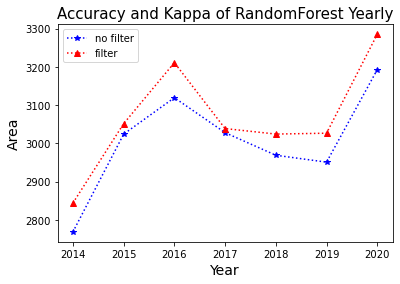

In [6]:
import matplotlib.pyplot as plt
import numpy as np
year = np.arange(2014,2021,1)
area1 = [2768.137082705315, 3023.9160873942606, 3119.293185935407, 3027.811917777078, 2968.7220503356652, 2950.620795963503, 3192.771557206194]
area2 = [2843.6785682158943, 3051.331479556907, 3210.976012656668, 3038.5171037183222, 3024.134208590113, 3026.390101973377, 3285.282480995821]
# plot permanent water and seasonal water(折线图)
plt.title("Accuracy and Kappa of RandomForest Yearly", fontsize=15)
plt.xlabel("Year", fontsize=14)
plt.ylabel('Area', fontsize=14)
plt.plot(year,area1,'*:b' ,label = 'no filter')
plt.plot(year,area2,'^:r',label='filter')
plt.legend()
plt.show()

In [ ]:
for i in range(2014,2021,1):
    landsat_images = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
        .filterBounds(wuhan18) \
        .filterDate('{}-01-01'.format(i), '{}-12-31'.format(i)) \
        .map(maskL8sr)
    print(landsat_images.size().getInfo())
    validPixel = landsat_images.count().select('B2').clip(wuhan18).rename('count')
    waterbody_number = landsat_images.map(AWEIsh).map(identify_water).sum().select('AWEI').rename('number')
    wuhan18_waterfrequency = waterbody_number.divide(validPixel).select('number').rename('frequency')
    wuhan18_permanentwater = wuhan18_waterfrequency.gt(0.75)
    waterarea = wuhan18_permanentwater.multiply(ee.Image.pixelArea()).divide(1e6)
    areas = waterarea.reduceRegion(**{
        'reducer': ee.Reducer.sum(),
        'geometry': wuhan18,
        'scale': 30,
        'maxPixels': 1e14
    })
    print("{} year,waterbody area in wuhan1+8 : {}".format(i,areas.getInfo().get('frequency')))

In [ ]:
# 'LANDSAT/LC08/C01/T1_SR'
# 'LANDSAT/LT05/C01/T1_SR'
landsat_images = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
    .filterBounds(wuhan18) \
    .filterDate('2014-01-01', '2014-12-31') \
    .filter(ee.Filter.lt('CLOUD_COVER',30)) \
    .map(maskL8sr)
Map.addLayer(landsat_images.mosaic().clip(wuhan18),visParams,'landsat_image')

print(landsat_images.size().getInfo())

In [ ]:
# 计算有效像元的个数
validPixel = landsat5_images.count().select('B2').clip(wuhan18).rename('count')
vis_validPixel = {'bands': ['count'], 'palette': ['ffffff', 'dd09ec'], 'min': 0.0, 'max': 40.0, 'opacity': 1.0}
Map.addLayer(validPixel,vis_validPixel,'validPixel')

# 计算某个像元判断为水体的个数
landsat5_awei = landsat5_images.map(AWEIsh)
waterbody_number = landsat5_awei.map(identify_water).sum().select('AWEI').rename('number')
# waterbody_number  = landsat5_images.map(AWEIsh).select('AWEI').sum().rename('number')
vis_waterNumber = {'bands': ['number'], 'palette': ['ffffff', 'dd09ec'], 'min': 0.0, 'max': 30.0, 'opacity': 1.0}
Map.addLayer(waterbody_number,vis_waterNumber,'waterbody number')

vis_frequency = {'bands': ['frequency'], 'palette': ['green', 'yellow','blue'], 'min': 0.0, 'max': 1.0, 'opacity': 1.0}
# 水体频率的计算 NM,./
wuhan18_waterfrequency = waterbody_number.divide(validPixel).select('number').rename('frequency')
Map.addLayer(wuhan18_waterfrequency,vis_frequency,"wuhan18 waterbody frequency")
# wuhan18_permanentwater = wuhan18_waterfrequency.gt(0.75).selfMask()
wuhan18_permanentwater = wuhan18_waterfrequency.gt(0.75)
Map.addLayer(wuhan18_permanentwater,{'min':0,'max':1,'palette':['white','blue']},"wuhan18 permanent waterbody")

In [ ]:
waterarea = wuhan18_permanentwater.multiply(ee.Image.pixelArea()).divide(1e6)
areas = waterarea.reduceRegion(**{
    'reducer': ee.Reducer.sum(),
    'geometry': wuhan18,
    'scale': 30,
    'maxPixels': 1e14
})
print(areas.get('frequency').getInfo())
# print("waterbody area in wuhan1+8 : {}".format(areas.getInfo().get('frequency')))

In [ ]:
# AWEI(自动水体提取指数): AWEIsh = B2 + 2.5B3 - 1.5(B5+B6) - 0.25B7
def AWEIsh0(image):
    awei = image.expression('B2 + 2.5*B3 - 1.5*(B5+B6) - 0.25*B7',
        {
          'B2': image.select('B2'),
          'B3': image.select('B3'),    
          'B5': image.select('B5'),    
          'B6': image.select('B6'),
          'B7': image.select('B7'),
        }).rename('AWEI')
    water_awei = awei.clip(wuhan18).select('AWEI').gt(0)
    return image.addBands(water_awei)